# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [28]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from IPython import display
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

# some help functions are contained in workspace_utils for proprietery protection, which include:
# clean_data(df)
# clean_data_svl(df)
# pca_results(full_dataset, pca, n_comp)
import workspace_utils 
# magic word for producing visualizations in notebook
%matplotlib inline

In [ ]:
!pip install xgboost
import xgboost as xgb

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Part 0.1: Load the Data and View the Data

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias_backup = azdias
customers_backup = customers

In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
print('Size of Azidas dataset is:',azdias.shape)
print('Size of customer dataset is:',customers.shape)

Size of Azidas dataset is: (891221, 366)
Size of customer dataset is: (191652, 369)


In [5]:
customers_additional_features = set(customers_backup.columns.tolist()) - set(azdias_backup.columns.tolist())
print(customers_additional_features)
customers.drop(columns=customers_additional_features, axis=1, inplace=True)

{'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'}


In [8]:
azdias.sample(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
175243,555813,2,2.0,12.0,NaN,NaN,NaN,NaN,12.0,2.0,...,2.0,3.0,6.0,7.0,6.0,9.0,3.0,3,2,4
818638,749335,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,8.0,...,1.0,8.0,11.0,8.0,6.0,9.0,3.0,3,1,4
174695,502890,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3
346465,457522,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,3.0,...,2.0,9.0,7.0,4.0,6.0,9.0,3.0,3,2,4
120093,393165,-1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,...,3.0,6.0,9.0,8.0,6.0,4.0,2.0,1,1,1
386781,605582,-1,9.0,20.0,NaN,NaN,NaN,NaN,20.0,8.0,...,2.0,6.0,9.0,9.0,6.0,4.0,3.0,1,1,1
583943,600171,-1,1.0,15.0,NaN,NaN,NaN,NaN,0.0,1.0,...,1.0,7.0,7.0,4.0,4.0,9.0,7.0,3,2,4
793940,398004,1,2.0,17.0,16.0,NaN,NaN,NaN,11.0,1.0,...,1.0,2.0,4.0,3.0,1.0,9.0,3.0,4,1,4
157633,669344,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,10.0,...,2.0,10.0,11.0,8.0,5.0,9.0,3.0,6,1,3
850202,520371,2,1.0,12.0,NaN,NaN,NaN,NaN,11.0,1.0,...,4.0,8.0,9.0,6.0,6.0,9.0,3.0,3,1,3


In [9]:
customers.sample(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
127279,4648,1,1.0,19.0,NaN,NaN,NaN,NaN,12.0,2.0,...,2.0,1.0,1.0,1.0,3.0,9.0,7.0,4,1,4
166587,163828,1,1.0,17.0,NaN,NaN,NaN,NaN,11.0,1.0,...,3.0,2.0,4.0,2.0,2.0,9.0,2.0,1,1,4
53173,118518,-1,1.0,21.0,NaN,NaN,NaN,NaN,24.0,1.0,...,0.0,2.0,4.0,2.0,1.0,9.0,7.0,1,1,4
53445,146279,-1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,11.0,...,4.0,2.0,1.0,1.0,6.0,3.0,4.0,3,1,4
2232,58952,3,1.0,17.0,NaN,NaN,NaN,NaN,9.0,1.0,...,2.0,3.0,3.0,2.0,2.0,9.0,1.0,1,1,3
61571,147965,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,2
3383,136175,1,1.0,11.0,NaN,NaN,NaN,NaN,11.0,1.0,...,4.0,5.0,8.0,6.0,6.0,9.0,3.0,3,2,3
132640,141972,0,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,1.0,2.0,1.0,6.0,9.0,2.0,1,1,4
21534,105108,0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,19.0,...,4.0,10.0,6.0,3.0,NaN,9.0,3.0,3,1,4
36696,83192,1,1.0,18.0,NaN,NaN,NaN,NaN,12.0,1.0,...,4.0,2.0,4.0,2.0,2.0,9.0,3.0,1,1,4


### Part 0.2: Replace nans from DIAS_attributes.xlsx file 

In [15]:
# Parse strings in features and encode to int
def extract_num(strs):
    nums = []
    str_as_num = strs.replace('[', '').replace(']','').split(',')
    for s in str_as_num:
        if s == 'X' or s == 'XX' or s == '':
            nums.append(s)
        else:
            nums.append(int(s))
    return nums

In [16]:
feat_unknown = pd.read_csv('feat_unkown.csv')
#feat_unknown

In [ ]:
for idx, col in enumerate(feat_unknown['Attribute']):
    item_to_change = extract_num(feat_unknown['Value'][idx])
    if col in azdias.columns.tolist():
        #print(idx, col, item_to_change)
        azdias[col].replace(item_to_change, np.nan, inplace=True)

### Part 0.3: Process with Missing Data
#### Part 0.3.1: Assess Missing Data in Each Column

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percent_null_count = (azdias.isnull().sum()/len(azdias))*100

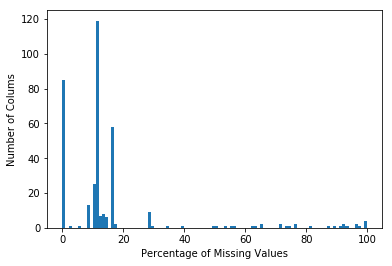

In [14]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(percent_null_count, bins=100)
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Colums')
plt.show()

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
percent_missing_over20 = percent_null_count[percent_null_count>20]
print(percent_missing_over20)

AGER_TYP                       76.019640
ALTER_HH                       34.813699
ALTER_KIND1                    90.904837
ALTER_KIND2                    96.690047
ALTER_KIND3                    99.307691
ALTER_KIND4                    99.864792
ALTERSKATEGORIE_FEIN           29.504130
D19_BANKEN_ANZ_12              93.325225
D19_BANKEN_ANZ_24              89.102479
D19_BANKEN_DATUM               76.112547
D19_BANKEN_OFFLINE_DATUM       97.791120
D19_BANKEN_ONLINE_DATUM        81.571462
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_GESAMT_ANZ_12              65.617507
D19_GESAMT_ANZ_24              56.697834
D19_GESAMT_DATUM               39.739863
D19_GESAMT_OFFLINE_DATUM       62.673344
D19_GESAMT_ONLINE_DATUM        50.604171
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_SOZIALES                   28.849522
D19_TELKO_ANZ_12               96.271295
D19_TELKO_ANZ_24

In [16]:
drop_col = percent_missing_over20.index.tolist()
print(drop_col)
azdias = azdias.drop(drop_col, axis=1)
azdias.head()

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


#### Part 0.3.2: Assess Missing Data in Each Row

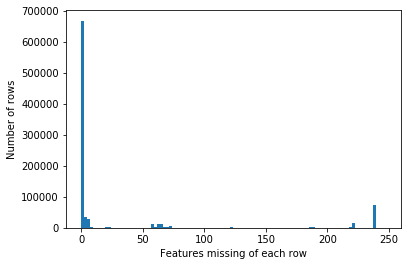

In [17]:
# How much data is missing in each row of the dataset?
feas_row_missing = azdias.isnull().sum(axis=1)
plt.hist(feas_row_missing, bins=100)
plt.xlabel('Features missing of each row')
plt.ylabel('Number of rows')
plt.show()

In [18]:
# Drop rows with missing features over 10
# values in each row.
azdias = azdias[feas_row_missing<11]

In [19]:
azdias.shape

(732486, 325)

In [20]:
categorical_feats = ['OST_WEST_KZ', 'CAMEO_INTL_2015', 'VERS_TYP']

In [21]:
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias['VERS_TYP'].replace([1, 2], [1, 0], inplace=True)
azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

In [22]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'];
azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015'];
azdias = azdias.drop('CAMEO_INTL_2015', axis=1);

wealth_dic = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

lifestage_dic = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

azdias['CAMEO_INTL_2015_WEALTH'].replace(wealth_dic, inplace=True)
azdias['CAMEO_INTL_2015_LIFESTAGE'].replace(lifestage_dic, inplace=True)

In [23]:
azdias['PRAEGENDE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'];
azdias['PRAEGENDE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'];
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1);
decade_dic = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dic = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
azdias['PRAEGENDE_DECADE'].replace(decade_dic, inplace=True)
azdias['PRAEGENDE_MOVEMENT'].replace(movement_dic, inplace=True)

In [24]:
azdias = pd.get_dummies(azdias, columns=['CAMEO_DEU_2015'])

In [25]:
azdias.drop(['LNR'], axis=1, inplace=True)

### Step 0.4: Create a Cleaning Function
"clean_data" function is imported from workspace_utilities

In [9]:
customer = clean_data(customers)

In [12]:
# Select 20% of Azdias dataset to test algorithm,
azdias_sample = azdias.sample(frac=0.2, random_state=1)
azdias_sample.shape

(178244, 366)

In [13]:
azdias_sample = clean_data(azdias_sample)

In [14]:
print('The shape of Azdias Dataset after cleaning is:', azdias_sample.shape)
print('The shape of Customer Dataset after cleaning is:', customer.shape)

The shape of Azdias Dataset after cleaning is: (146323, 369)
The shape of Customer Dataset after cleaning is: (131203, 369)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Step 1.1: Feature Transformation

### Step 1.1.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [15]:
azdias_sample.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
337901,9.0,3.0,0.0,1.0,2.0,3.0,0.0,NaN,6.0,4,...,0,0,0,0,0,0,0,0,0,0
215064,1.0,1.0,0.0,1.0,3.0,1.0,0.0,4.0,2.0,2,...,0,0,0,0,0,0,0,0,0,0
678552,1.0,1.0,0.0,0.0,3.0,1.0,0.0,5.0,3.0,6,...,0,0,0,0,0,0,0,0,0,0
849379,4.0,27.0,0.0,0.0,2.0,23.0,0.0,4.0,1.0,7,...,0,0,0,0,0,0,0,0,0,0
700557,1.0,18.0,0.0,0.0,1.0,17.0,0.0,4.0,1.0,9,...,0,0,0,0,0,0,0,1,0,0


In [30]:
# Impute the Nans, 
my_imputer = Imputer()
azdias_data = my_imputer.fit_transform(azdias_sample)

In [31]:
# Apply feature scaling to the general population demographics data.
my_scaler = StandardScaler()
azdias_data = my_scaler.fit_transform(azdias_data)

In [32]:
print(azdias_data.shape)
print(azdias_data[:10])


(146323, 368)
[[ 1.25984979 -0.34138069 -0.12632584 ..., -0.17953243 -0.19363429
  -0.07358332]
 [-0.93647885 -0.4712195  -0.12632584 ..., -0.17953243 -0.19363429
  -0.07358332]
 [-0.93647885 -0.4712195  -0.12632584 ..., -0.17953243 -0.19363429
  -0.07358332]
 ..., 
 [ 1.25984979 -0.40630009 -0.12632584 ..., -0.17953243 -0.19363429
  -0.07358332]
 [-0.93647885 -0.40630009 -0.12632584 ..., -0.17953243 -0.19363429
  -0.07358332]
 [-0.11285561 -0.40630009 -0.12632584 ..., -0.17953243 -0.19363429
  -0.07358332]]


The dataset is copied to a new dataset, and the nans are replaced with the mean value of each column, and then the dataset is been scaled to mean 0 and standard deviation 1.

### Step 1.1.2: Perform Dimensionality Reduction

On the scaled data, we'll apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [40]:
# Apply PCA to the data.
my_pca = PCA(180)
azdias_pca = my_pca.fit_transform(azdias_data)

In [35]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


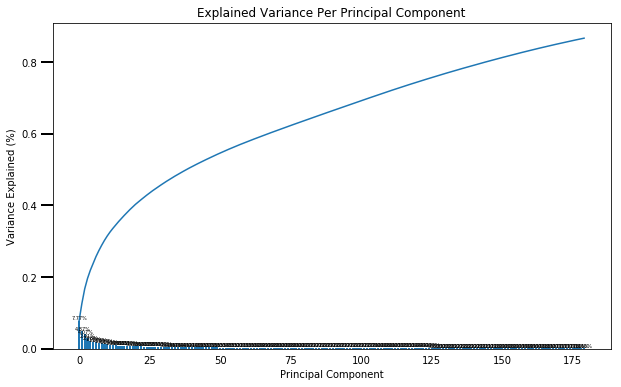

In [41]:
scree_plot(my_pca)

PCA is applied to reduced the component to 180, which is number of around half of total features, the result contains over 85% of total information. 
To further reduce the components' number, PCA is applied that reduce features to components, and over 60% information is retained with this procedure.  

### Step 1.1.3: Interpret Principal Components
Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list.

In [45]:
pca = PCA(125)
azdias_pca = pca.fit_transform(azdias_data)

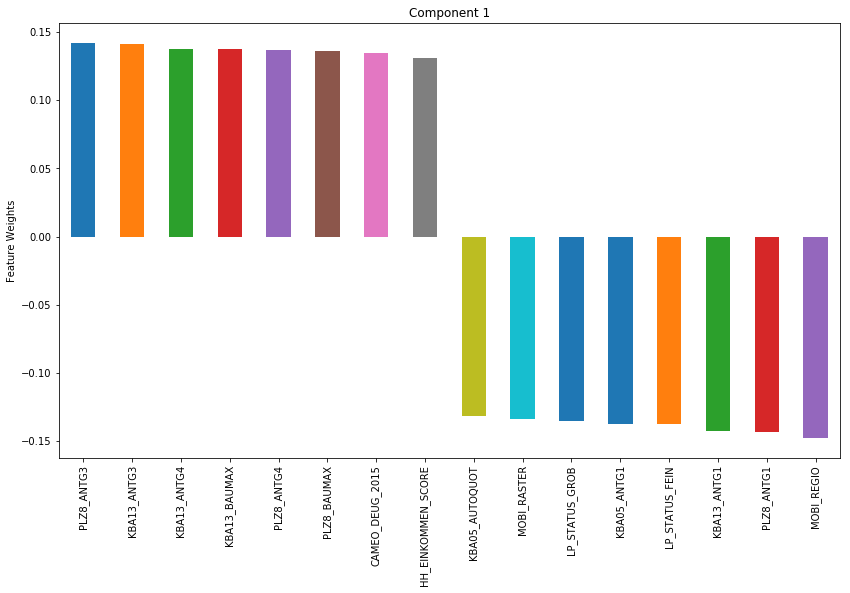

In [47]:
pca_results(azdias_sample, pca, 1)

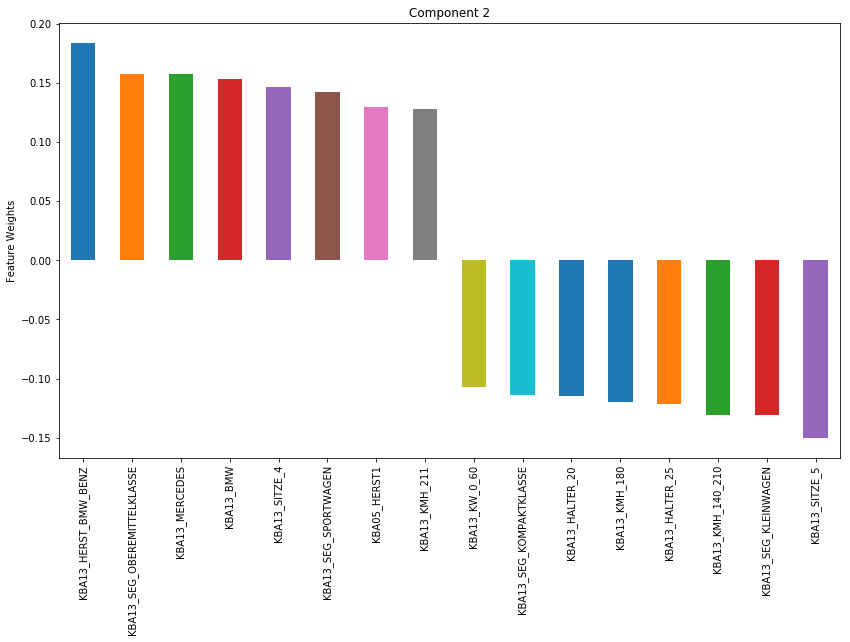

In [48]:
pca_results(azdias_sample, pca, 2)

## Step 1.2: Clustering
### Step 1.2.1: Apply Clustering to General Population
We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

Use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.
Then, compute the average difference from each point to its assigned cluster's center. 
Perform the above two steps for a number of different cluster counts. we can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. Warning: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take.

In [51]:
# To avoid super long training time, record time of each training 
import time

In [52]:
with active_session():
    
    my_score = []
    for ii in range(10, 31, 2):
        begin = time.time()
        my_kmean = KMeans(ii)
        my_kmean = my_kmean.fit(azdias_pca)
        my_score.append(np.abs(my_kmean.score(azdias_pca)))
        # compute the average within-cluster distances.
        end = time.time()
        print('time cost for k=', str(ii), ' the calculation time is ', end-begin, 's')   

time cost for k= 10  the calculation time is  137.06454992294312 s
time cost for k= 12  the calculation time is  107.28474521636963 s
time cost for k= 14  the calculation time is  128.54601311683655 s
time cost for k= 16  the calculation time is  139.2239179611206 s
time cost for k= 18  the calculation time is  152.2283492088318 s
time cost for k= 22  the calculation time is  190.2558672428131 s
time cost for k= 24  the calculation time is  197.88987922668457 s
time cost for k= 26  the calculation time is  224.804137468338 s
time cost for k= 28  the calculation time is  213.29807782173157 s
time cost for k= 30  the calculation time is  275.4175434112549 s


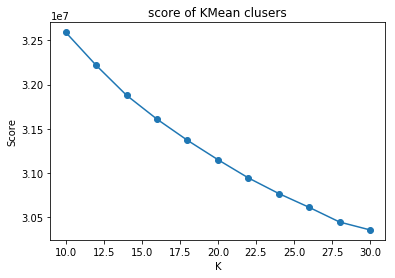

In [53]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(10, 31, 2), my_score, marker='o', linestyle='-')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('score of KMean clusers')
plt.show()

In [54]:
# With the elbow method, cluster numebr of 28 can be selected from above plots
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
with active_session():
    import time
    begin = time.time()
    my_kmean = KMeans(28)
    my_kmean = my_kmean.fit(azdias_pca)
    print(np.abs(my_kmean.score(azdias_pca)))
    end = time.time()
    print('time cost for the calculation is ', end-begin, 's')

30474822.0662
time cost for the calculation is  231.13235235214233 s


In [55]:
azdias_predict = my_kmean.predict(azdias_pca)

### Step 1.2.2: Apply All Steps to the Customer Data
Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. 

In [56]:
# Apply imputer, scaler, and pca transform to customer dataset, then predict the data with kmean cluster 
customers_data = my_imputer.transform(customer)
customers_data = my_scaler.transform(customers_data)
customers_pca= pca.transform(customers_data)
customers_pred = my_kmean.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data
At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.


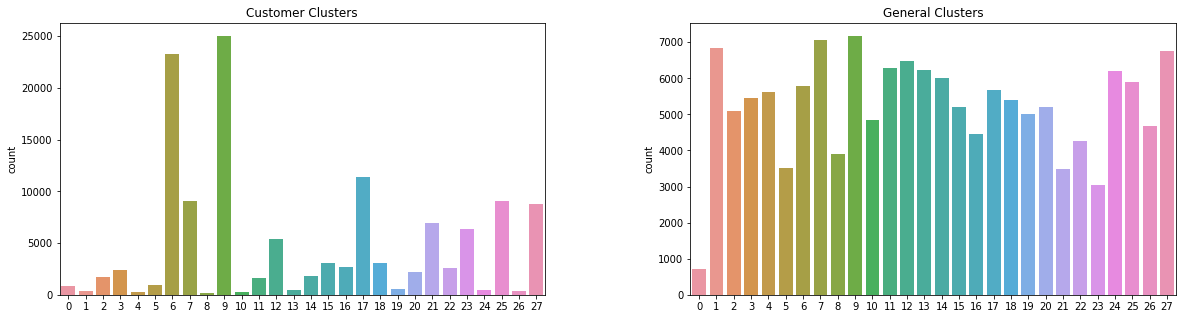

In [60]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_predict, ax=axs[1])
axs[1].set_title('General Clusters')
plt.show()

In [61]:
np.bincount(customers_pred)/len(customers_pred)*100

array([  0.63336966,   0.29115188,   1.31246999,   1.79797718,
         0.17834958,   0.70577654,  17.75492938,   6.88246458,
         0.15853296,  19.07273462,   0.24313468,   1.2027164 ,
         4.07460195,   0.33002294,   1.38487687,   2.3612265 ,
         2.07083679,   8.64614376,   2.36198867,   0.45502008,
         1.6539256 ,   5.31161635,   1.97785112,   4.83373094,
         0.34450432,   6.93734137,   0.30791979,   6.71478549])

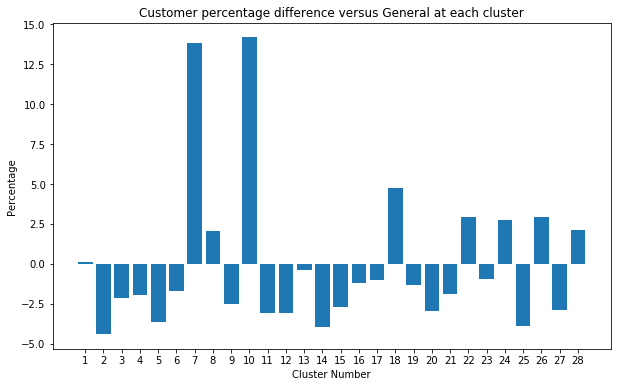

[  0.13584023  -4.39027209  -2.16203504  -1.93007651  -3.67066937
  -1.70396082  13.80886486   2.06367327  -2.51568777  14.16919929
  -3.06598282  -3.08437449  -0.36010756  -3.92358039  -2.71905758
  -1.20007282  -0.98063153   4.76500409  -1.33121062  -2.96276113
  -1.90053953   2.92921577  -0.92668201   2.75476864  -3.90294824
   2.90721624  -2.89116716   2.08803508]


In [65]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ax.bar(range(1, 29), np.bincount(customers_pred)/len(customers_pred)*100 - np.bincount(azdias_predict)/len(azdias_predict)*100)
ax.set_title('Customer percentage difference versus General at each cluster')
ax.set_ylabel('Percentage')
ax.set_xlabel('Cluster Number')
ax.set_xticks(range(1, 29))
plt.show()
print(np.bincount(customers_pred)/len(customers_pred)*100 - np.bincount(azdias_predict)/len(azdias_predict)*100)

In [66]:
def plot_scaled_comparison(df_sample, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
            pca.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(
            columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

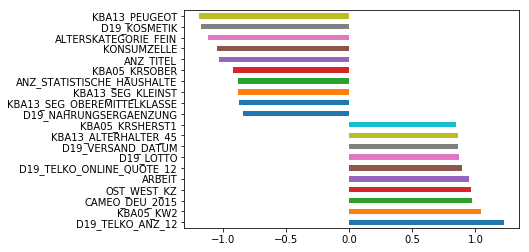

In [67]:
plot_scaled_comparison(customers, my_kmean, 7)

In [69]:
# sanity check
cluster = 7;
cluster_center = np.around(my_kmean.cluster_centers_[cluster-1], decimals=2)
clusters_sorted = cluster_center[np.argsort(cluster_center)[:]]
print(cluster_center)
print(clusters_sorted)
pca_pre = np.around(pca.inverse_transform(my_kmean.cluster_centers_[cluster-1]), decimals=2)
pca_pre_index = np.argsort(pca_pre)
pca_pre_sorted = pca_pre[np.argsort(pca_pre)[:]]
feature_customer_pre = list(azdias.columns.values)
print(list(customers.columns.values))
print('\n Top three correlated features are \n-----\n %s '% feature_customer_pre[pca_pre_index[0]], \
          feature_customer_pre[pca_pre_index[1]], feature_customer_pre[pca_pre_index[2]])

[-5.95  4.54  3.6   0.39  0.97  0.76  0.8   1.13 -0.45  0.05 -0.22  0.35
 -0.57 -0.71  0.02  0.05 -0.03 -0.44  0.55  0.03  0.15 -0.   -0.53  0.05
  0.33 -0.03 -0.17  0.01 -0.22 -0.11  0.14  0.21  0.52  0.19  0.09  0.46
 -0.09 -0.17 -0.09 -0.04 -0.05  0.17 -0.28  0.03 -0.14 -0.18 -0.23  0.03
 -0.01 -0.17 -0.24  0.07 -0.08  0.08  0.03 -0.08 -0.16 -0.14  0.14 -0.07
  0.03 -0.02  0.    0.04  0.13  0.07  0.03 -0.08 -0.02  0.03  0.08 -0.15
 -0.21  0.04 -0.08  0.01  0.11 -0.16 -0.05  0.03 -0.1  -0.    0.2  -0.15
 -0.01 -0.06  0.14 -0.02  0.26  0.14  0.04 -0.04 -0.05  0.01  0.05 -0.03
 -0.05 -0.05 -0.13  0.04 -0.03  0.01  0.14  0.04 -0.17  0.13  0.11  0.
 -0.12 -0.2   0.01 -0.05 -0.    0.04 -0.01 -0.    0.06 -0.05  0.06  0.05
  0.02  0.   -0.03  0.07  0.03]
[-5.95 -0.71 -0.57 -0.53 -0.45 -0.44 -0.28 -0.24 -0.23 -0.22 -0.22 -0.21
 -0.2  -0.18 -0.17 -0.17 -0.17 -0.17 -0.16 -0.16 -0.15 -0.15 -0.14 -0.14
 -0.13 -0.12 -0.11 -0.1  -0.09 -0.09 -0.08 -0.08 -0.08 -0.08 -0.07 -0.06
 -0.05 -0.05 -0.05 -0

In [68]:
# check the component values of each cluster, 

def cluster_centers(cluster, features):
    cluster_center = np.around(my_kmean.cluster_centers_[cluster-1], decimals=2)
    clusters_sorted = cluster_center[np.argsort(cluster_center)[:]]
    pca_pre = np.around(pca.inverse_transform(my_kmean.cluster_centers_[cluster-1]), decimals=2)
    pca_pre_index = np.argsort(pca_pre)
    pca_pre_sorted = pca_pre[np.argsort(pca_pre)[:]]
    print('Cluster %s' % cluster)
    print('sorted array\n-----\n Top 3: %s \n Bottom 3: %s '% (np.flip(clusters_sorted[-3:],0), clusters_sorted[:3]))
    print('\n original array\n-----\n %s'% cluster_center)
    
    print('PCA sorted\n-----\n Top 3: %s \n Bottom 3: %s '% (np.flip(pca_pre_sorted[-3:],0), pca_pre_sorted[:3]))
    print('\n pre PCA is \n-----\n %s'% pca_pre)
    print('\n Top three correlated features are \n-----\n %s '% features[pca_pre_index[0]], \
          features[pca_pre_index[1]], features[pca_pre_index[2]])
    print('\n Top three negative correlated features are \n-----\n %s'% features[pca_pre_index[-1]], \
          features[pca_pre_index[-2]], features[pca_pre_index[-3]])

In [73]:
features_pre = list(azdias_sample.columns.values)
cluster_centers(10, features_pre)

Cluster 10
sorted array
-----
 Top 3: [ 3.14  1.26  0.78] 
 Bottom 3: [-5.68 -1.63 -1.24] 

 original array
-----
 [-5.68  0.51  1.26  3.14 -1.63 -0.41  0.78  0.31  0.26 -0.08 -1.24 -0.09
 -0.27 -0.93 -0.07  0.26  0.35  0.   -0.08 -0.14 -0.26  0.04 -0.14 -0.23
  0.23  0.15 -0.15  0.15 -0.08  0.26  0.06  0.18  0.2   0.14 -0.04  0.4
 -0.11 -0.26  0.12 -0.01  0.02  0.11 -0.12  0.04  0.2   0.01 -0.1   0.08
 -0.06  0.06 -0.02  0.02 -0.04  0.11 -0.   -0.12 -0.1  -0.13  0.02 -0.01
 -0.07  0.03  0.01  0.06  0.07 -0.02  0.1  -0.   -0.11 -0.1  -0.01 -0.05
  0.11 -0.03  0.03  0.03  0.03  0.06 -0.09 -0.04  0.06  0.05 -0.08  0.07
 -0.01  0.03 -0.1   0.01 -0.06 -0.07 -0.04 -0.04  0.07 -0.04  0.02 -0.04
 -0.02  0.01  0.02 -0.08 -0.    0.03 -0.07  0.06  0.   -0.09  0.03  0.02
  0.03  0.06  0.05 -0.06 -0.03  0.04 -0.03  0.   -0.01  0.02 -0.04 -0.03
  0.1  -0.05 -0.03 -0.03 -0.02]
PCA sorted
-----
 Top 3: [ 1.33  1.27  1.24] 
 Bottom 3: [-1.17 -1.15 -1.13] 

 pre PCA is 
-----
 [-0.7  -0.43 -0.11  0.11 

In [74]:
# customer data compared to the general population?
cluster_centers(2, features_pre)

Cluster 2
sorted array
-----
 Top 3: [ 1.69  1.54  1.36] 
 Bottom 3: [-4.26 -2.96 -2.35] 

 original array
-----
 [ 1.54  1.69 -4.26 -2.35  1.36 -2.96  0.95  0.28  0.35 -0.38 -0.19 -0.24
 -0.25  0.09 -0.12 -0.08 -0.25  0.1  -0.19 -0.05 -0.2   0.19 -0.11  0.3
  0.15 -0.1   0.09 -0.04 -0.09 -0.06  0.03  0.01  0.24 -0.07 -0.14  0.
 -0.11 -0.02  0.22  0.2  -0.06 -0.07  0.03  0.   -0.11  0.02  0.04 -0.02
 -0.12 -0.06  0.02  0.05 -0.03 -0.08 -0.18 -0.29 -0.08  0.09 -0.12 -0.13
 -0.01  0.04 -0.1  -0.17  0.03  0.01  0.04 -0.09  0.1   0.01 -0.04  0.
  0.07  0.02 -0.01 -0.05  0.08  0.02  0.01 -0.03 -0.02 -0.04  0.02 -0.01
 -0.03 -0.06  0.   -0.   -0.03 -0.01 -0.03 -0.02 -0.01  0.    0.03 -0.07
 -0.05  0.04  0.03  0.03 -0.07 -0.05  0.02  0.07 -0.02  0.05  0.02 -0.01
  0.02 -0.02  0.04  0.05  0.05 -0.02  0.03  0.01 -0.08  0.03  0.01 -0.03
  0.09 -0.08  0.02 -0.01 -0.01]
PCA sorted
-----
 Top 3: [ 1.31  1.25  1.13] 
 Bottom 3: [-1.2  -1.19 -1.11] 

 pre PCA is 
-----
 [ 0.58 -0.03 -0.06 -0.   -0.39

### Step 3.4: Subconclusion: Unsupervised Learning Findings

The total counts of each cluster for General and Customer dataset are plotted respectively, I then differentiate the percentage of Customer results from General results, and found that Cluster10 is overpresented with a difference of 14.16%, and Cluster2 is underpresented with a difference of -4.39%. Then the features that correlated to the two clusters are further investigated through inverse transformation of PCA.

On Cluster10, we find PRAEGENDE_MOVEMENT is the highest impacted feature, which represented a dominating movement of a person's youth, and HH_EINKOMMEN_SCORE is the 2nd, it shows the income of a household also impact the customer distribution.VK_DISTANZ is the 3rd positive impact factor. While the negatively correlated features are: LP_LEBENSPHASE_FEIN LP_LEBENSPHASE_GROB LP_STATUS_GROB, it shows the financial type of prepared people is more tend to be customer, the higher-income families are more likely to be a potential customer.
On Cluster2, the highest impacted feature CJT_TYP_6 FINANZ_MINIMALIST CJT_TYP_3, it shows advertising strategy is important, while store-shopper and Advertising-Enthusiast with restricted Cross-Channel-Behaviour are important features. On the negative correlation features, CJT_TYP_1 and CJT_TYP_2 show that advertising method of Consumptiontraditionalist and Consumptionminimalist are less likely to be potential customers, and SEMIO_RAT shows rational personality people are less likely to be the customer.

## Part 2: Supervised Learning Model

Now that we've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, we can verify the model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, we'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Part 2.1: Load Data for Supervised Learning

In [40]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={18:'str',19:'str'})

In [42]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:'str',19:'str'})

In [5]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [6]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [43]:
# Get y_train from training data
y_reg = mailout_train['RESPONSE']
del mailout_train['RESPONSE']
len_train, len_test = len(mailout_train), len(mailout_test)
# Concat train and test data
df_svl = pd.concat([mailout_train, mailout_test])

In [44]:
y_reg.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [45]:
df_svl.shape

(85795, 366)

From the value counts of "response" labels, we can see the dataset is highly imbalanced, with only around 1% of the total dataset are labeled as positive. Therefore the StratifiedKFold method is applied to handle this issue.  

### Part 2.1 Cleaning Data in Supervised Learning

In [19]:
for idx, col in enumerate(feat_unknown['Attribute']):
        item_to_change = extract_num(feat_unknown['Value'][idx])
        if col in df_svl.columns.tolist():
            #print(idx, col, item_to_change)
            df_svl[col].replace(item_to_change, np.nan, inplace=True)

In [20]:
df_percent_null_count = (df_svl.isnull().sum()/len(df_svl))*100
df_percent_missing_over20 = df_percent_null_count[df_percent_null_count>20]
print(df_percent_missing_over20)

AGER_TYP                     41.913864
ALTER_HH                     30.780349
ALTER_KIND1                  95.336558
ALTER_KIND2                  98.230666
ALTER_KIND3                  99.562912
ALTER_KIND4                  99.906754
D19_BANKEN_ANZ_12            93.540416
D19_BANKEN_ANZ_24            90.068186
D19_BANKEN_DATUM             78.709715
D19_BANKEN_OFFLINE_DATUM     95.940323
D19_BANKEN_ONLINE_DATUM      85.834839
D19_GESAMT_ANZ_12            58.755172
D19_GESAMT_ANZ_24            48.063407
D19_GESAMT_DATUM             27.972493
D19_GESAMT_OFFLINE_DATUM     41.799639
D19_GESAMT_ONLINE_DATUM      46.201993
D19_TELKO_ANZ_12             95.750335
D19_TELKO_ANZ_24             92.519378
D19_TELKO_DATUM              78.056996
D19_TELKO_ONLINE_DATUM       98.893875
D19_VERSAND_ANZ_12           64.379043
D19_VERSAND_ANZ_24           54.272393
D19_VERSAND_DATUM            34.391282
D19_VERSAND_OFFLINE_DATUM    46.239291
D19_VERSAND_ONLINE_DATUM     50.785011
D19_VERSI_ANZ_12         

In [47]:
# clean_data_svl(df) function is imported from workspace_utils
df_svl_cleaned = clean_data_svl(df_svl)
df_svl_cleaned.shape

(85795, 310)

In [48]:
imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
df_svl_impute = imputer.fit_transform(df_svl_cleaned)

In [49]:
scaler = StandardScaler()
df_svl_scaler = scaler.fit_transform(df_svl_impute)

### Part 2.3: Training with Classfication Method

In [50]:
# Split the dataset to train and test
train_data = df_svl_scaler[:len_train]
test_data = df_svl_scaler[len_train:]

In [51]:
# Split the dataset into Train Test dataset, Strafity is selected for y_train
X_train, X_test, y_train, y_test = train_test_split(train_data, y_reg, stratify=y_reg, test_size=0.2)

In [52]:
print(X_train.shape)
print(y_train.shape)

(34369,)

In [53]:
def grid_search(clf, param_grid, X_train=X_train, y_train=y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [54]:
# use default values
clf_rf = RandomForestClassifier(random_state=5)
grid_search(clf_rf, {})

0.514747419649


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
clf_gb = GradientBoostingClassifier(random_state=5)
grid_search(clf_gb, {})

0.746349723297


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [58]:
clf_xgb = xgb.XGBClassifier(random_state=5)
grid_search(clf_xgb, {})

0.754647560907


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [64]:
# use default values
clf = xgb.XGBClassifier(random_state=5)
# use gridsearch to find best fitted model of XGBoost
parameters = {'eta': [0.001, 0.01, 0.1],
              'max_depth': [3, 5, 10],
              'min_child_weight' : [1, 3, 5]
             }


with active_session():
    best_predicer = grid_search(clf, parameters, X_train, y_train)

0.756223515495


In [65]:
best_predicter

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eta=0.001, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=5,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [66]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
lnr = mailout_test['LNR']

In [74]:
results = best_predicer.predict_proba(test_data)
results

array([[ 0.95302236,  0.04697763],
       [ 0.97343582,  0.0265642 ],
       [ 0.99681139,  0.00318863],
       ..., 
       [ 0.96880317,  0.03119683],
       [ 0.97627062,  0.02372936],
       [ 0.98215175,  0.01784823]], dtype=float32)

In [71]:
output_result = pd.DataFrame({'LNR':lnr, 'RESPONSE':results[:,0]})

In [ ]:
output_result.head(10)

In [73]:
output_result.to_csv(path_or_buf='./result.csv', index=False)

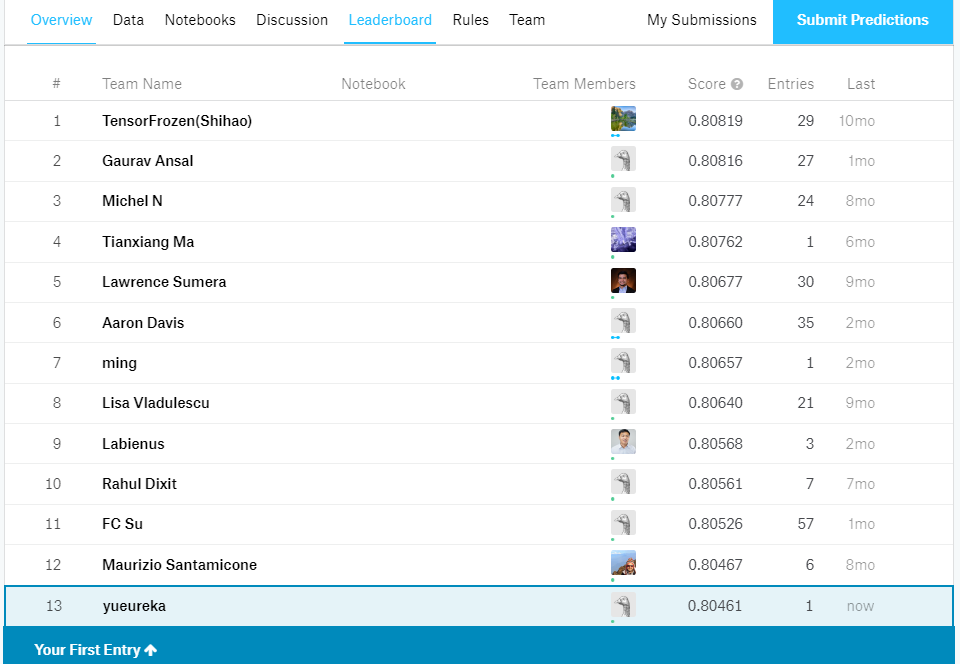

In [10]:
from IPython.display import Image
Image('KaggleResults.PNG')